In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Data Load

In [2]:
!unzip Drone_RCS_Measurement_Dataset.zip

Archive:  Drone_RCS_Measurement_Dataset.zip
   creating: Drone_RCS_Measurement_Dataset/
  inflating: Drone_RCS_Measurement_Dataset/battery_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/F450_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/Heli_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/Hexa_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/Hexa_VV.csv  
  inflating: Drone_RCS_Measurement_Dataset/M100_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/M100_HV.csv  
  inflating: Drone_RCS_Measurement_Dataset/M100_VH.csv  
  inflating: Drone_RCS_Measurement_Dataset/M100_VV.csv  
  inflating: Drone_RCS_Measurement_Dataset/Mavic_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/P4P_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/P4P_VV.csv  
  inflating: Drone_RCS_Measurement_Dataset/Parrot_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/Walkera_HH.csv  
  inflating: Drone_RCS_Measurement_Dataset/Walkera_VV.csv  
  inflating: Drone_RCS_Measurement_Dataset/Y600

In [3]:
import os

def extract_series(df: pd.DataFrame):
    df = df[df['f[GHz]'] == 40]
    df = df.drop('f[GHz]', axis=1)
    df = df.groupby('phi[deg]')
    ans = []
    for phi, data in df:
        if data['theta[deg]'].max() == 95:
            data = data[(data['theta[deg]'] <= 90) & (data['theta[deg]'] >= -90)]
        data = data.sort_values('theta[deg]', axis=0).reset_index()
        ans.append(data['RCS[dB]'])
    return np.array(ans)


data_files = ['F450_HH.csv', 'Heli_HH.csv', 'Hexa_HH.csv', 'M100_HH.csv',
              'Mavic_HH.csv', 'P4P_HH.csv', 'Walkera_HH.csv', 'Y600_HH.csv']
data = {}
for filename in os.listdir('Drone_RCS_Measurement_Dataset'):
    if filename in data_files:
        file_path = os.path.join('Drone_RCS_Measurement_Dataset', filename)
        data[filename[:-4]] = extract_series(pd.read_csv(file_path))

# BSS and GAF

In [22]:
def gaf_transform(series):
    min_v, max_v = np.min(series, axis=1)[:, np.newaxis], np.max(series, axis=1)[:, np.newaxis]
    series = (series - max_v + series-min_v)/(max_v - min_v)
    series = series.clip(-1, 1)
    theta = np.arccos(series)
    G = series[:, :, np.newaxis] * series[:, np.newaxis, :]
    GASF = np.cos(theta[:, :, np.newaxis] + theta[:, np.newaxis, :])
    GADF = np.cos(theta[:, :, np.newaxis] - theta[:, np.newaxis, :])
    return np.stack((G, GASF, GADF), axis=1)

In [35]:
transformed_data = { k: torch.tensor(gaf_transform(v), dtype=torch.float32) for k, v in data.items()}

# HCCSANet

In [36]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avgpool = nn.AvgPool2d(3, stride=2)
        self.conv = nn.Conv2d(in_channels, out_channels, 1, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.skip_conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=2)
        self.skip_conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)

    def forward(self, x):
        return self.bn(self.conv(self.avgpool(x))) + self.skip_conv2(self.skip_conv1(x))

class ConvBlock(nn.Module):
    def __init__(self, in_channels, size=1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(in_channels))
        for _ in range(size-1):
            self.block.append(nn.Conv2d(in_channels, in_channels, 3, stride=1, padding=1))
            self.block.append(nn.ReLU())
            self.block.append(nn.BatchNorm2d(in_channels))

    def forward(self, x):
        return self.block(x)

class HCCSA(nn.Module):
    def __init__(self, channels, height, width, reduction=16):
        super().__init__()
        self.channels = channels
        self.reduction = reduction

        self.channel_attention1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.LeakyReLU())
        self.channel_attention2 = nn.Sequential(
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid())

        self.spatial_attention1 = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 5, padding=2),
            nn.LayerNorm([channels // reduction, height, width]),
            nn.LeakyReLU())
        self.spatial_attention2 = nn.Sequential(
            nn.Conv2d(channels // reduction, channels, 5, padding=2),
            nn.LayerNorm([channels, height, width]),
            nn.Sigmoid())

    def forward(self, x):
        sa1 = self.spatial_attention1(x)
        f3 = self.channel_attention2(self.channel_attention1(x) * sa1)
        f4 = self.spatial_attention2(sa1)
        return x * f3 * f4


In [62]:
class HCCSANet(nn.Module):
    def __init__(self, classes=8):
        super().__init__()
        self.input_block = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(3, stride=2))
        self.conv_block0 = ConvBlock(64, size=4)
        self.res_block1 = ResBlock(64, 128)
        self.conv_block1 = ConvBlock(128, size=2)
        self.res_block2 = ResBlock(128, 256)
        self.conv_block2 = ConvBlock(256, size=2)
        self.hccsa2 = HCCSA(256, 10, 10)
        self.res_block3 = ResBlock(256, 512)
        self.conv_block3 = ConvBlock(512, size=2)
        self.hccsa3 = HCCSA(512, 4, 4)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(nn.Conv2d(512, 512, 1, stride=1),
                                  nn.LeakyReLU(),
                                  nn.Dropout(0.5),
                                  nn.Conv2d(512, classes, 1, stride=1))

        self.loss_fn = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.input_block(x)
        x = self.res_block1(self.conv_block0(x) + x)
        x = self.res_block2(self.conv_block1(x) + x)
        x = self.res_block3(self.conv_block2(x) + self.hccsa2(x) + x)
        return self.head(self.gap(self.conv_block3(x) + self.hccsa3(x) + x))

    def train_step(self,x_batch, y_batch):
        self.train()
        output = self.forward(x_batch)
        loss = self.loss_fn(output.squeeze(), y_batch.squeeze())
        return loss

    @torch.inference_mode()
    def val_step(self, x_batch, y_batch):
        self.eval()
        logits = self.forward(x_batch)
        loss = self.loss_fn(logits.squeeze(), y_batch.squeeze())
        pred = torch.argmax(logits.squeeze(), dim=-1)
        acc = f1_score(y_batch.cpu().numpy(), pred.cpu().numpy(), average='micro')
        return loss.item(), acc

# Dataset and augmentations

In [38]:
class Drone_RCS_Datasets:
    def __init__(
        self,
        data,
        test_size: float = 0.1,
        val_size: float = 2/7,
        random_state: int = 42,
        transforms = None
    ):

        self.idx2label = {}
        self.num_classes = len(self.idx2label)

        all_features = []
        all_labels = []

        for class_idx, (class_name, class_tensor) in enumerate(data.items()):
            num_samples = class_tensor.size(0)
            all_features.append(class_tensor)
            all_labels.append(torch.full((num_samples,), class_idx))
            self.idx2label[class_idx] = class_name

        self.features = torch.cat(all_features, dim=0)
        self.labels = torch.cat(all_labels, dim=0)

        features_np = self.features.numpy()
        labels_np = self.labels.numpy()

        X_temp, X_test, y_temp, y_test = train_test_split(
            self.features, self.labels,
            test_size=test_size,
            stratify=labels_np,
            random_state=random_state
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size,
            stratify=y_temp,
            random_state=random_state
        )

        to_add_features = [X_train]
        to_add_labels = [y_train]
        for transform in transforms:
            to_add_features.append(transform(X_train))
            to_add_labels.append(y_train)
        X_train = torch.cat(to_add_features, dim=0)
        y_train = torch.cat(to_add_labels, dim=0)

        self.train_dataset = TensorDataset(
            X_train, y_train
        )
        self.val_dataset = TensorDataset(
            X_val, y_val
        )
        self.test_dataset = TensorDataset(
            X_test, y_test
        )


Cutout from: https://github.com/uoguelph-mlrg/Cutout

In [39]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.

    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        B, C, H, W = img.size()
        mask = torch.ones((B, 1, H, W), dtype=torch.float32)

        for n in range(self.n_holes):
            y = torch.randint(0, H, (B,))
            x = torch.randint(0, W, (B,))

            y1 = (y - self.length // 2).clamp(0, H)
            y2 = (y + self.length // 2).clamp(0, H)
            x1 = (x - self.length // 2).clamp(0, W)
            x2 = (x + self.length // 2).clamp(0, W)

            for b in range(B):
                mask[b, 0, y1[b]:y2[b], x1[b]:x2[b]] = 0.

        img = img * mask

        return img

class GaussianNoise:
    def __init__(self, mean=0, std=1):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        noise = torch.randn(img.size())

        return (img + noise).clamp(-1, 1)

In [40]:
data_augmentations = [GaussianNoise(), Cutout(1, 20)]
drone_datasets = Drone_RCS_Datasets(transformed_data, test_size=0.1, val_size=2/7, transforms=data_augmentations)

# Training

In [56]:
def plot_learning_curve(
    train_loss,
    val_loss=None,
    val_metrics=None,
    metric_name='Accuracy',
    title='Training Metrics',
    figsize=(14, 5),
    savepath=None
):
    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    if val_loss is not None:
        plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Evolution')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    plt.legend()

    if val_metrics:
        plt.subplot(1, 2, 2)
        if val_metrics is not None:
            plt.plot(val_metrics, label=f'Validation {metric_name}')
        plt.title(f'{metric_name} Evolution')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name)
        plt.grid(True, alpha=0.3)
        plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()

In [57]:
def train_model(model, epochs, train_dataloader, val_dataloader, device, checkpoint_path=None):
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_metric': []
    }
    optimizer = torch.optim.AdamW(model.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1,  gamma=0.9)
    model = model.to(device)
    for epoch in range(epochs):
        train_loss = 0
        train_metrics = []

        for x_batch, y_batch in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Train]'):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            loss = model.train_step(x_batch, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss

        train_loss = train_loss / len(train_dataloader)

        val_loss = 0
        val_metrics = []
        if val_dataloader is not None:
            for x_batch, y_batch in tqdm(val_dataloader, desc=f'Epoch {epoch+1}/{epochs} [Val]'):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                loss, metrics = model.val_step(x_batch, y_batch)
                val_loss += loss
                val_metrics.append(metrics)
            val_loss = val_loss / len(val_dataloader)
            val_metric = sum(val_metrics)/len(val_dataloader)
        scheduler.step()

        history['train_loss'].append(train_loss.item())
        if val_dataloader is not None:
            history['val_loss'].append(val_loss)
            history['val_metric'].append(val_metric)
        print(f'\nEpoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss.item():.4f}')
        if val_dataloader is not None:
            print(f'Val Loss: {val_loss:.4f}', f'\|Val metric: {val_metric:.4f}')
        if checkpoint_path is not None:
            if len(history['val_metric']) == 1 or history['val_metric'][-1] > max(history['val_metric'][:-1]):
                torch.save(model.state_dict(), checkpoint_path)
    if checkpoint_path:
        best_model_state_dict = torch.load(checkpoint_path)
        model.load_state_dict(best_model_state_dict)
    finetuned_model = model
    return finetuned_model, history

In [43]:
!mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [63]:
train_dataloader = DataLoader(drone_datasets.train_dataset, 64, shuffle=True)
val_dataloader = DataLoader(drone_datasets.val_dataset, 64, shuffle=False)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
hccsanet = HCCSANet()

In [65]:
trained_hccsanet, history = train_model(hccsanet, 30, train_dataloader, val_dataloader,
                                        device=DEVICE, checkpoint_path='./checkpoints/model0.pt')

Epoch 1/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/30
Train Loss: 5.3979
Val Loss: 3.0778 \|Val metric: 0.1867


Epoch 2/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 2/30
Train Loss: 1.7526
Val Loss: 1.7349 \|Val metric: 0.3076


Epoch 3/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 3/30
Train Loss: 1.4786
Val Loss: 1.4957 \|Val metric: 0.3868


Epoch 4/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 4/30
Train Loss: 1.3293
Val Loss: 1.5073 \|Val metric: 0.4045


Epoch 5/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 5/30
Train Loss: 1.1777
Val Loss: 0.9912 \|Val metric: 0.5854


Epoch 6/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 6/30
Train Loss: 1.0875
Val Loss: 1.0301 \|Val metric: 0.5724


Epoch 7/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 7/30
Train Loss: 0.9404
Val Loss: 1.0141 \|Val metric: 0.5928


Epoch 8/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 8/30
Train Loss: 0.8143
Val Loss: 0.8621 \|Val metric: 0.6522


Epoch 9/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 9/30
Train Loss: 0.7551
Val Loss: 1.0761 \|Val metric: 0.6064


Epoch 10/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 10/30
Train Loss: 0.6693
Val Loss: 0.9965 \|Val metric: 0.6173


Epoch 11/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 11/30
Train Loss: 0.5944
Val Loss: 0.9515 \|Val metric: 0.6689


Epoch 12/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 12/30
Train Loss: 0.5408
Val Loss: 0.8742 \|Val metric: 0.6986


Epoch 13/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 13/30
Train Loss: 0.4411
Val Loss: 0.8977 \|Val metric: 0.7091


Epoch 14/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 14/30
Train Loss: 0.3527
Val Loss: 0.8758 \|Val metric: 0.7341


Epoch 15/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 15/30
Train Loss: 0.2848
Val Loss: 0.9604 \|Val metric: 0.7549


Epoch 16/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 16/30
Train Loss: 0.2191
Val Loss: 0.7490 \|Val metric: 0.7768


Epoch 17/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 17/30
Train Loss: 0.1578
Val Loss: 0.9134 \|Val metric: 0.7695


Epoch 18/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 18/30
Train Loss: 0.1555
Val Loss: 0.8991 \|Val metric: 0.7914


Epoch 19/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 19/30
Train Loss: 0.1013
Val Loss: 0.9374 \|Val metric: 0.7784


Epoch 20/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 20/30
Train Loss: 0.0929
Val Loss: 0.9964 \|Val metric: 0.7909


Epoch 21/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 21/30
Train Loss: 0.0622
Val Loss: 0.9784 \|Val metric: 0.7846


Epoch 22/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 22/30
Train Loss: 0.0523
Val Loss: 1.1613 \|Val metric: 0.7940


Epoch 23/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 23/30
Train Loss: 0.0503
Val Loss: 1.1374 \|Val metric: 0.7700


Epoch 24/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 24/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 24/30
Train Loss: 0.0385
Val Loss: 1.0641 \|Val metric: 0.7846


Epoch 25/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 25/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 25/30
Train Loss: 0.0321
Val Loss: 0.9920 \|Val metric: 0.7993


Epoch 26/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 26/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 26/30
Train Loss: 0.0207
Val Loss: 1.0601 \|Val metric: 0.7982


Epoch 27/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 27/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 27/30
Train Loss: 0.0177
Val Loss: 0.9800 \|Val metric: 0.8034


Epoch 28/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 28/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 28/30
Train Loss: 0.0123
Val Loss: 1.0401 \|Val metric: 0.8034


Epoch 29/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 29/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 29/30
Train Loss: 0.0122
Val Loss: 1.1187 \|Val metric: 0.8123


Epoch 30/30 [Train]:   0%|          | 0/44 [00:00<?, ?it/s]

Epoch 30/30 [Val]:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 30/30
Train Loss: 0.0115
Val Loss: 1.1313 \|Val metric: 0.7982


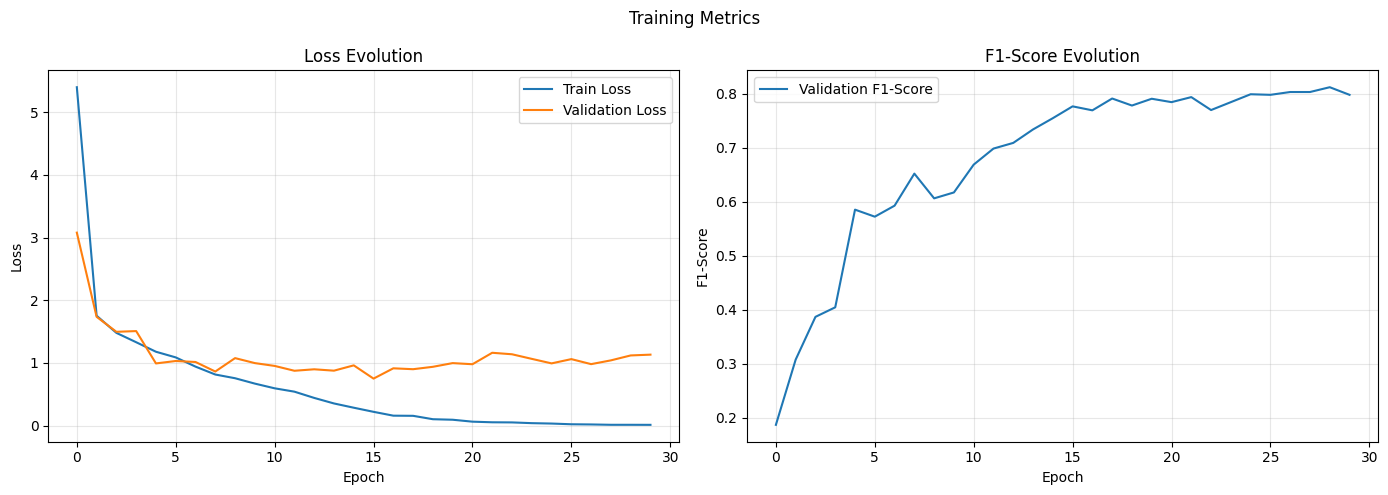

In [66]:
plot_learning_curve(train_loss=history['train_loss'], val_loss=history['val_loss'],
                    val_metrics=history['val_metric'], metric_name='F1-Score',
                    savepath='learncurve')

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_article_metrics(model, test_loader, device, num_classes: int = 8, idx2class=None,
                              figsize=(14, 5), output_path='./confusion_matrix'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            preds = torch.argmax(logits.squeeze(), dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    overall_accuracy = accuracy_score(all_labels, all_preds)

    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))

    class_metrics = []
    total_samples = len(all_labels)

    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP
        TN = total_samples - (TP + FP + FN)

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        class_accuracy = (TP + TN) / total_samples

        class_metrics.append({
            "class": idx2class[i] if idx2class else i,
            "TP": int(TP),
            "FP": int(FP),
            "FN": int(FN),
            "TN": int(TN),
            "Accuracy": class_accuracy,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "F1": f1
        })

    avg_accuracy = np.mean([m["Accuracy"] for m in class_metrics])
    avg_precision = np.mean([m["Precision"] for m in class_metrics])
    avg_recall = np.mean([m["Recall"] for m in class_metrics])
    avg_specificity = np.mean([m["Specificity"] for m in class_metrics])
    avg_f1 = np.mean([m["F1"] for m in class_metrics])

    # Создаем фигуру для визуализации
    plt.figure(figsize=figsize)

    # Создаем heatmap с помощью seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=idx2class.values(),
                yticklabels=idx2class.values(),
                cbar=False)

    # Добавляем подписи
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)

    # Поворачиваем подписи по оси X для лучшей читаемости
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=0, fontsize=12)

    # Добавляем сетку для лучшей читаемости
    plt.grid(False)

    # Регулируем отступы
    plt.tight_layout()

    # Сохраняем изображение
    plt.savefig(output_path, bbox_inches='tight')
    plt.close()

    print(f"Confusion matrix сохранена в: {output_path}")

    return {
        "overall_accuracy": overall_accuracy,
        "per_class_metrics": class_metrics,
        "average_metrics": {
            "Accuracy": avg_accuracy,
            "Precision": avg_precision,
            "Recall": avg_recall,
            "Specificity": avg_specificity,
            "F1": avg_f1
        }
    }

In [71]:
test_dataloader = DataLoader(drone_datasets.test_dataset, 64, shuffle=False)
calculate_article_metrics(trained_hccsanet, test_dataloader, DEVICE, idx2class=drone_datasets.idx2label)

Confusion matrix сохранена в: ./confusion_matrix


{'overall_accuracy': 0.8206896551724138,
 'per_class_metrics': [{'class': 'Mavic_HH',
   'TP': 16,
   'FP': 3,
   'FN': 2,
   'TN': 124,
   'Accuracy': np.float64(0.9655172413793104),
   'Precision': np.float64(0.8421052631578947),
   'Recall': np.float64(0.8888888888888888),
   'Specificity': np.float64(0.9763779527559056),
   'F1': np.float64(0.8648648648648649)},
  {'class': 'M100_HH',
   'TP': 18,
   'FP': 1,
   'FN': 0,
   'TN': 126,
   'Accuracy': np.float64(0.993103448275862),
   'Precision': np.float64(0.9473684210526315),
   'Recall': np.float64(1.0),
   'Specificity': np.float64(0.9921259842519685),
   'F1': np.float64(0.972972972972973)},
  {'class': 'Y600_HH',
   'TP': 16,
   'FP': 2,
   'FN': 2,
   'TN': 125,
   'Accuracy': np.float64(0.9724137931034482),
   'Precision': np.float64(0.8888888888888888),
   'Recall': np.float64(0.8888888888888888),
   'Specificity': np.float64(0.984251968503937),
   'F1': np.float64(0.8888888888888888)},
  {'class': 'Heli_HH',
   'TP': 11,
 